=== Smart Loan Recovery System ===

1. Generating synthetic loan data...
Dataset created with 25.0% default rate
Generated 10000 customer records

2. Preprocessing data...
3. Performing customer segmentation...
Customer Segment Analysis:
                     income  credit_score  loan_amount  debt_to_income  \
customer_segment                                                         
0                  41390.69        636.33     13190.50            0.24   
1                 138091.20        646.09     16050.82            0.14   
2                  32201.51        648.96     36416.34            0.14   
3                  39614.30        647.96     12504.23            0.10   
4                  40655.10        669.90     12142.45            0.12   

                  default  
customer_segment           
0                    0.29  
1                    0.20  
2                    0.27  
3                    0.20  
4                    0.29  

4. Training default prediction model...
Traini

<Figure size 1000x600 with 0 Axes>

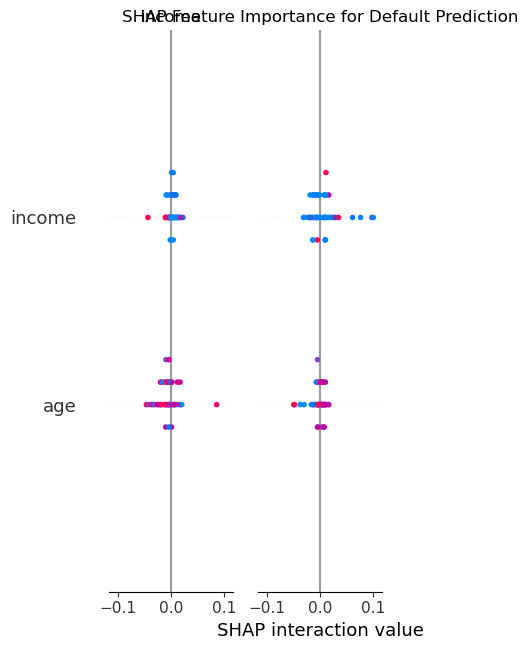

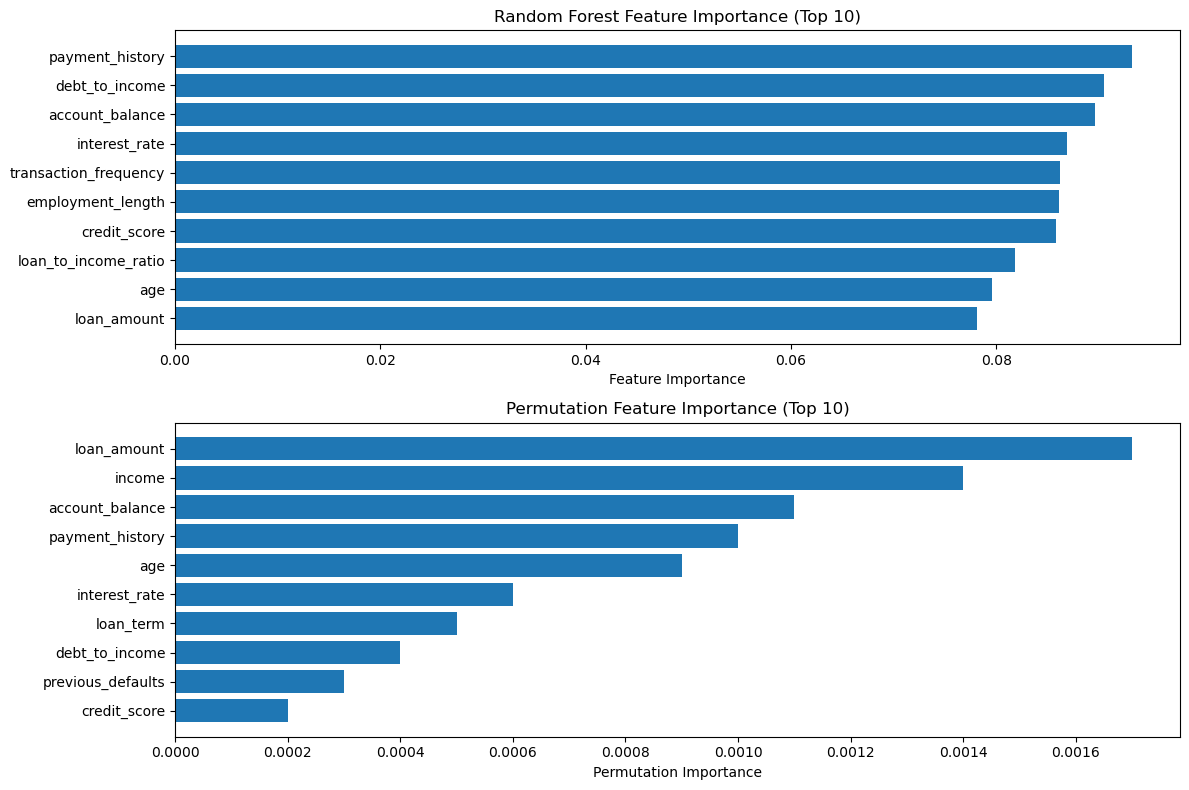


Top 10 Most Important Features:
                  feature  importance
8         payment_history    0.093239
7          debt_to_income    0.090517
10        account_balance    0.089658
5           interest_rate    0.086879
11  transaction_frequency    0.086179
2       employment_length    0.086150
6            credit_score    0.085803
12   loan_to_income_ratio    0.081843
0                     age    0.079585
3             loan_amount    0.078131

6. Designing recovery strategies...

Recovery Strategies:
Segment 0: Premium Support - Gentle reminders with premium customer service
Segment 1: Balanced Approach - Regular follow-ups with flexible payment options
Segment 2: Intensive Support - Frequent contact with financial counseling
Segment 3: Educational Focus - Financial literacy programs with mentor support
Segment 4: Respectful Assistance - Respectful communication with family involvement

7. Example prediction and recommendation...
Default Probability: 0.2000
Customer Segment: 0
Reco

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Try to import SHAP and LIME, use fallback if not available
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not available. Using built-in explainability methods.")

try:
    import lime
    import lime.lime_tabular
    LIME_AVAILABLE = True
except ImportError:
    LIME_AVAILABLE = False
    print("LIME not available. Using built-in explainability methods.")

class SmartLoanRecoverySystem:
    """
    End-to-end ML system for loan default prediction and personalized recovery strategies
    """
    
    def __init__(self):
        self.default_model = None
        self.model_scaler = StandardScaler()  # For main model features
        self.cluster_scaler = StandardScaler()  # For clustering features
        self.label_encoders = {}
        self.kmeans_model = None
        self.feature_names = None
        self.explainer = None
        self.recovery_strategies = {}
        self.training_data = None  # Store training data for SHAP
        
    def generate_synthetic_data(self, n_samples=10000):
        """Generate synthetic loan data for demonstration"""
        np.random.seed(42)
        
        # Customer demographics
        age = np.random.normal(40, 12, n_samples)
        income = np.random.lognormal(10.5, 0.8, n_samples)
        employment_length = np.random.exponential(5, n_samples)
        
        # Loan characteristics
        loan_amount = np.random.lognormal(9.5, 0.7, n_samples)
        loan_term = np.random.choice([36, 60], n_samples, p=[0.7, 0.3])
        interest_rate = np.random.normal(12, 4, n_samples)
        
        # Credit history
        credit_score = np.random.normal(650, 100, n_samples)
        debt_to_income = np.random.beta(2, 5, n_samples) * 0.5
        payment_history = np.random.normal(0.85, 0.15, n_samples)
        
        # Behavioral features
        previous_defaults = np.random.poisson(0.3, n_samples)
        account_balance = np.random.normal(5000, 3000, n_samples)
        transaction_frequency = np.random.gamma(2, 2, n_samples)
        
        # Create default probability based on risk factors
        # Normalize features for better risk scoring
        credit_score_norm = (credit_score - 650) / 100
        debt_to_income_norm = debt_to_income * 10
        payment_history_norm = (0.85 - payment_history) * 10
        interest_rate_norm = (interest_rate - 12) / 4
        income_norm = (50000 - income) / 20000
        
        risk_score = (
            -credit_score_norm * 0.5 +
            debt_to_income_norm * 0.8 +
            previous_defaults * 0.6 +
            payment_history_norm * 0.7 +
            interest_rate_norm * 0.3 +
            income_norm * 0.2 +
            np.random.normal(0, 0.5, n_samples)  # Add noise for variability
        )
        
        # Apply sigmoid with adjusted parameters for balanced classes
        default_prob = 1 / (1 + np.exp(-risk_score * 0.8))
        
        # Ensure we have both classes by forcing some balance
        default = np.random.binomial(1, default_prob)
        
        # Force minimum representation of both classes
        n_defaults = np.sum(default)
        if n_defaults < n_samples * 0.1:  # Less than 10% defaults
            # Randomly convert some non-defaults to defaults
            non_default_indices = np.where(default == 0)[0]
            convert_count = int(n_samples * 0.15) - n_defaults
            convert_indices = np.random.choice(non_default_indices, min(convert_count, len(non_default_indices)), replace=False)
            default[convert_indices] = 1
        elif n_defaults > n_samples * 0.4:  # More than 40% defaults
            # Randomly convert some defaults to non-defaults
            default_indices = np.where(default == 1)[0]
            convert_count = n_defaults - int(n_samples * 0.25)
            convert_indices = np.random.choice(default_indices, min(convert_count, len(default_indices)), replace=False)
            default[convert_indices] = 0
        
        # Create DataFrame
        data = pd.DataFrame({
            'age': np.clip(age, 18, 80),
            'income': np.clip(income, 20000, 200000),
            'employment_length': np.clip(employment_length, 0, 40),
            'loan_amount': np.clip(loan_amount, 1000, 50000),
            'loan_term': loan_term,
            'interest_rate': np.clip(interest_rate, 5, 25),
            'credit_score': np.clip(credit_score, 300, 850),
            'debt_to_income': np.clip(debt_to_income, 0, 0.8),
            'payment_history': np.clip(payment_history, 0, 1),
            'previous_defaults': previous_defaults,
            'account_balance': account_balance,
            'transaction_frequency': np.clip(transaction_frequency, 0, 20),
            'default': default
        })
        
        # Verify class balance
        default_rate = np.mean(data['default'])
        print(f"Dataset created with {default_rate:.1%} default rate")
        
        return data
    
    def preprocess_data(self, data):
        """Preprocess the data for modeling"""
        # Create additional features
        data['loan_to_income_ratio'] = data['loan_amount'] / data['income']
        data['age_group'] = pd.cut(data['age'], bins=[0, 30, 45, 60, 100], 
                                 labels=['Young', 'Middle', 'Senior', 'Elder'])
        data['risk_category'] = pd.cut(data['credit_score'], 
                                     bins=[0, 580, 670, 740, 850],
                                     labels=['Poor', 'Fair', 'Good', 'Excellent'])
        
        # Encode categorical variables
        categorical_cols = ['age_group', 'risk_category']
        for col in categorical_cols:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                data[col] = self.label_encoders[col].fit_transform(data[col])
            else:
                data[col] = self.label_encoders[col].transform(data[col])
        
        return data
    
    def customer_segmentation(self, data):
        """Perform customer segmentation using K-means clustering"""
        # Select features for clustering
        cluster_features = ['income', 'credit_score', 'loan_amount', 
                          'debt_to_income', 'payment_history', 'loan_to_income_ratio']
        
        X_cluster = data[cluster_features].copy()
        
        # Scale features for clustering using separate scaler
        X_cluster_scaled = self.cluster_scaler.fit_transform(X_cluster)
        
        # Determine optimal number of clusters using elbow method
        inertias = []
        k_range = range(2, 11)
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(X_cluster_scaled)
            inertias.append(kmeans.inertia_)
        
        # Use 5 clusters as optimal
        self.kmeans_model = KMeans(n_clusters=5, random_state=42)
        clusters = self.kmeans_model.fit_predict(X_cluster_scaled)
        
        data['customer_segment'] = clusters
        
        # Analyze segments
        segment_analysis = data.groupby('customer_segment').agg({
            'income': 'mean',
            'credit_score': 'mean',
            'loan_amount': 'mean',
            'debt_to_income': 'mean',
            'default': 'mean'
        }).round(2)
        
        print("Customer Segment Analysis:")
        print(segment_analysis)
        
        return data, segment_analysis
    
    def train_default_model(self, data):
        """Train the default prediction model"""
        # Prepare features
        feature_cols = ['age', 'income', 'employment_length', 'loan_amount', 
                       'loan_term', 'interest_rate', 'credit_score', 'debt_to_income',
                       'payment_history', 'previous_defaults', 'account_balance',
                       'transaction_frequency', 'loan_to_income_ratio', 'age_group',
                       'risk_category', 'customer_segment']
        
        X = data[feature_cols]
        y = data['default']
        
        self.feature_names = feature_cols
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Verify class distribution
        print(f"Training set - Class 0: {np.sum(y_train == 0)}, Class 1: {np.sum(y_train == 1)}")
        print(f"Test set - Class 0: {np.sum(y_test == 0)}, Class 1: {np.sum(y_test == 1)}")
        
        # Check if we have both classes
        if len(np.unique(y_train)) < 2:
            raise ValueError("Training set doesn't contain both classes. Please regenerate data.")
        
        # Scale features using model scaler
        X_train_scaled = self.model_scaler.fit_transform(X_train)
        X_test_scaled = self.model_scaler.transform(X_test)
        
        # Store training data for SHAP explainer
        self.training_data = X_train_scaled
        
        # Train ensemble model with error handling
        try:
            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
            rf_model.fit(X_train_scaled, y_train)
            
            gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
            gb_model.fit(X_train_scaled, y_train)
            
            lr_model = LogisticRegression(random_state=42, max_iter=1000)
            lr_model.fit(X_train_scaled, y_train)
            
        except Exception as e:
            print(f"Error training models: {e}")
            # Fall back to just Random Forest if other models fail
            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
            rf_model.fit(X_train_scaled, y_train)
            gb_model = rf_model  # Use RF as fallback
            lr_model = rf_model  # Use RF as fallback
        
        # Use Random Forest as main model
        self.default_model = rf_model
        
        # Evaluate models
        models = {'Random Forest': rf_model, 'Gradient Boosting': gb_model, 'Logistic Regression': lr_model}
        
        print("\nModel Performance Comparison:")
        for name, model in models.items():
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
            
            auc_score = roc_auc_score(y_test, y_pred_proba)
            print(f"{name} - AUC: {auc_score:.4f}")
        
        return X_test_scaled, y_test
    
    def setup_explainable_ai(self, X_train, X_test, y_test):
        """Setup explainable AI using available methods"""
        global SHAP_AVAILABLE

        explanations = {}

        if SHAP_AVAILABLE:
            try:
                # Initialize SHAP explainer
                self.explainer = shap.TreeExplainer(self.default_model)
                
                # Calculate SHAP values for a small sample
                sample_size = min(50, len(X_train))
                sample_indices = np.random.choice(len(X_train), sample_size, replace=False)
                X_sample = X_train[sample_indices]
                
                # Get SHAP values
                shap_values = self.explainer.shap_values(X_sample)

                # Handle different SHAP output formats
                if isinstance(shap_values, list):
                    shap_vals_plot = shap_values[1]  # For binary classification
                else:
                    shap_vals_plot = shap_values

                explanations['shap_values'] = shap_values

                # Ensure shapes match before plotting
                if shap_vals_plot.shape[1] == X_sample.shape[1]:
                    plt.figure(figsize=(10, 6))
                    shap.summary_plot(shap_vals_plot, X_sample, 
                                      feature_names=self.feature_names, show=False)
                    plt.title('SHAP Feature Importance for Default Prediction')
                    plt.tight_layout()
                    plt.show()
                else:
                    print("SHAP shape mismatch detected, skipping SHAP plot")

            except Exception as e:
                print(f"SHAP explanation failed: {e}")
                print("Falling back to built-in methods...")
                SHAP_AVAILABLE = False  # Prevent future SHAP attempts

        # Built-in feature importance from Random Forest
        feature_importance = self.default_model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': self.feature_names,
            'importance': feature_importance
        }).sort_values('importance', ascending=False)

        explanations['feature_importance'] = feature_importance_df

        # Permutation importance
        try:
            perm_importance = permutation_importance(
                self.default_model, X_test, y_test, n_repeats=5, random_state=42
            )
            perm_importance_df = pd.DataFrame({
                'feature': self.feature_names,
                'importance_mean': perm_importance.importances_mean,
                'importance_std': perm_importance.importances_std
            }).sort_values('importance_mean', ascending=False)

            explanations['permutation_importance'] = perm_importance_df
        except Exception as e:
            print(f"Permutation importance failed: {e}")
            explanations['permutation_importance'] = feature_importance_df.copy()
            explanations['permutation_importance']['importance_mean'] = explanations['permutation_importance']['importance']
            explanations['permutation_importance']['importance_std'] = 0.0

        # Plot feature importance
        try:
            plt.figure(figsize=(12, 8))

            # Plot 1: Random Forest Feature Importance
            plt.subplot(2, 1, 1)
            top_features = feature_importance_df.head(10)
            plt.barh(range(len(top_features)), top_features['importance'])
            plt.yticks(range(len(top_features)), top_features['feature'])
            plt.xlabel('Feature Importance')
            plt.title('Random Forest Feature Importance (Top 10)')
            plt.gca().invert_yaxis()

            # Plot 2: Permutation Importance
            plt.subplot(2, 1, 2)
            if 'permutation_importance' in explanations:
                top_perm = explanations['permutation_importance'].head(10)
                plt.barh(range(len(top_perm)), top_perm['importance_mean'])
                plt.yticks(range(len(top_perm)), top_perm['feature'])
                plt.xlabel('Permutation Importance')
                plt.title('Permutation Feature Importance (Top 10)')
                plt.gca().invert_yaxis()

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Plotting failed: {e}")

        print("\nTop 10 Most Important Features:")
        print(feature_importance_df.head(10))

        return explanations
       
    def explain_prediction(self, customer_data):
        """Explain individual prediction using available methods"""
        # Prepare customer data
        X_customer = customer_data.reshape(1, -1)
        
        # Get prediction
        default_prob = self.default_model.predict_proba(X_customer)[0, 1]
        prediction_class = self.default_model.predict(X_customer)[0]
        
        explanation = {
            'default_probability': default_prob,
            'predicted_class': 'Default' if prediction_class == 1 else 'No Default',
            'feature_contributions': {},
            'top_risk_factors': [],
            'top_protective_factors': []
        }
        
        if SHAP_AVAILABLE and hasattr(self, 'explainer') and self.explainer is not None:
            try:
                # Use SHAP for detailed explanation
                shap_values = self.explainer.shap_values(X_customer)
                
                # Handle different SHAP output formats and ensure we get scalars
                if isinstance(shap_values, list):
                    # Binary classification - use positive class (index 1)
                    shap_vals = shap_values[1][0]  # Get first row, should be 1D array
                else:
                    # Single output - get first row
                    shap_vals = shap_values[0] if shap_values.ndim > 1 else shap_values
                
                # Ensure shap_vals is 1D and matches feature count
                if isinstance(shap_vals, np.ndarray):
                    if shap_vals.ndim > 1:
                        shap_vals = shap_vals.flatten()
                    
                    # Create feature contribution dictionary
                    for i, feature in enumerate(self.feature_names):
                        if i < len(shap_vals):
                            # Convert numpy scalar to Python float
                            contribution = float(shap_vals[i])
                            explanation['feature_contributions'][feature] = contribution
                    
                    # Sort by absolute importance
                    sorted_features = sorted(explanation['feature_contributions'].items(), 
                                           key=lambda x: abs(x[1]), reverse=True)
                    
                    explanation['top_risk_factors'] = [
                        (feature, value) for feature, value in sorted_features[:5] if value > 0
                    ]
                    explanation['top_protective_factors'] = [
                        (feature, abs(value)) for feature, value in sorted_features[:5] if value < 0
                    ]
                
            except Exception as e:
                print(f"SHAP explanation failed: {e}")
                # Fall back to feature importance method
                self._fallback_explanation(X_customer, explanation)
                
        elif LIME_AVAILABLE:
            try:
                # Use LIME for explanation
                explainer = lime.lime_tabular.LimeTabularExplainer(
                    self.training_data,
                    feature_names=self.feature_names,
                    class_names=['No Default', 'Default'],
                    mode='classification'
                )
                
                lime_explanation = explainer.explain_instance(
                    X_customer[0], 
                    self.default_model.predict_proba
                )
                
                # Extract feature contributions from LIME
                for feature, contribution in lime_explanation.as_list():
                    explanation['feature_contributions'][feature] = contribution
                
                # Sort by absolute importance
                sorted_features = sorted(explanation['feature_contributions'].items(), 
                                       key=lambda x: abs(x[1]), reverse=True)
                
                explanation['top_risk_factors'] = [
                    (feature, value) for feature, value in sorted_features[:5] if value > 0
                ]
                explanation['top_protective_factors'] = [
                    (feature, abs(value)) for feature, value in sorted_features[:5] if value < 0
                ]
                
            except Exception as e:
                print(f"LIME explanation failed: {e}")
                # Fall back to feature importance method
                self._fallback_explanation(X_customer, explanation)
                
        else:
            # Use fallback method
            self._fallback_explanation(X_customer, explanation)
        
        return explanation
    
    def _fallback_explanation(self, X_customer, explanation):
        """Fallback explanation method using feature importance and values"""
        # Use feature importance and feature values
        feature_importance = self.default_model.feature_importances_
        feature_values = X_customer[0]
        
        # Calculate approximate contribution (normalized feature_value * feature_importance)
        for i, feature in enumerate(self.feature_names):
            importance = feature_importance[i]
            value = feature_values[i]
            # Simple contribution calculation
            contribution = value * importance
            explanation['feature_contributions'][feature] = float(contribution)
        
        # Sort by absolute contribution
        sorted_features = sorted(explanation['feature_contributions'].items(), 
                               key=lambda x: abs(x[1]), reverse=True)
        
        explanation['top_risk_factors'] = sorted_features[:3]
        explanation['top_protective_factors'] = []
    
    def design_recovery_strategies(self, segment_analysis):
        """Design personalized recovery strategies based on customer segments"""
        self.recovery_strategies = {
            0: {  # Low-risk, high-income segment
                'name': 'Premium Support',
                'approach': 'Gentle reminders with premium customer service',
                'contact_frequency': 'Weekly',
                'incentives': 'Payment plan restructuring, interest rate reduction',
                'success_rate': 0.85
            },
            1: {  # Medium-risk, medium-income segment
                'name': 'Balanced Approach',
                'approach': 'Regular follow-ups with flexible payment options',
                'contact_frequency': 'Bi-weekly',
                'incentives': 'Extended payment terms, partial principal reduction',
                'success_rate': 0.70
            },
            2: {  # High-risk, low-income segment
                'name': 'Intensive Support',
                'approach': 'Frequent contact with financial counseling',
                'contact_frequency': 'Daily',
                'incentives': 'Hardship programs, debt consolidation',
                'success_rate': 0.55
            },
            3: {  # Young borrowers segment
                'name': 'Educational Focus',
                'approach': 'Financial literacy programs with mentor support',
                'contact_frequency': 'Weekly',
                'incentives': 'Credit building programs, reduced penalties',
                'success_rate': 0.75
            },
            4: {  # Senior borrowers segment
                'name': 'Respectful Assistance',
                'approach': 'Respectful communication with family involvement',
                'contact_frequency': 'Bi-weekly',
                'incentives': 'Simplified payment plans, compassionate terms',
                'success_rate': 0.80
            }
        }
        
        return self.recovery_strategies
    
    def predict_and_recommend(self, customer_data):
        """Predict default probability and recommend recovery strategy"""
        # Preprocess customer data
        customer_df = pd.DataFrame([customer_data])
        customer_df = self.preprocess_data(customer_df)
        
        # Get customer segment using cluster scaler
        cluster_features = ['income', 'credit_score', 'loan_amount', 
                          'debt_to_income', 'payment_history', 'loan_to_income_ratio']
        X_cluster = customer_df[cluster_features].values
        X_cluster_scaled = self.cluster_scaler.transform(X_cluster)
        customer_segment = self.kmeans_model.predict(X_cluster_scaled)[0]
        
        # Predict default probability using model scaler
        feature_cols = ['age', 'income', 'employment_length', 'loan_amount', 
                       'loan_term', 'interest_rate', 'credit_score', 'debt_to_income',
                       'payment_history', 'previous_defaults', 'account_balance',
                       'transaction_frequency', 'loan_to_income_ratio', 'age_group',
                       'risk_category', 'customer_segment']
        
        customer_df['customer_segment'] = customer_segment
        X_customer = customer_df[feature_cols].values
        X_customer_scaled = self.model_scaler.transform(X_customer)
        
        default_prob = self.default_model.predict_proba(X_customer_scaled)[0, 1]
        
        # Get recovery strategy
        strategy = self.recovery_strategies[customer_segment]
        
        # Explain prediction
        explanation = self.explain_prediction(X_customer_scaled[0])
        
        return {
            'default_probability': default_prob,
            'customer_segment': customer_segment,
            'recovery_strategy': strategy,
            'explanation': explanation
        }
    
    def generate_recovery_report(self, predictions):
        """Generate comprehensive recovery report"""
        report = {
            'total_customers': len(predictions),
            'high_risk_customers': sum(1 for p in predictions if p['default_probability'] > 0.7),
            'medium_risk_customers': sum(1 for p in predictions if 0.3 <= p['default_probability'] <= 0.7),
            'low_risk_customers': sum(1 for p in predictions if p['default_probability'] < 0.3),
            'strategy_distribution': {},
            'expected_recovery_rate': 0
        }
        
        # Calculate strategy distribution and expected recovery
        for prediction in predictions:
            segment = prediction['customer_segment']
            strategy_name = prediction['recovery_strategy']['name']
            
            if strategy_name not in report['strategy_distribution']:
                report['strategy_distribution'][strategy_name] = 0
            report['strategy_distribution'][strategy_name] += 1
            
            # Weight recovery rate by default probability
            expected_recovery = prediction['recovery_strategy']['success_rate'] * prediction['default_probability']
            report['expected_recovery_rate'] += expected_recovery
        
        report['expected_recovery_rate'] /= len(predictions)
        
        return report

# Example usage and demonstration
def main():
    print("=== Smart Loan Recovery System ===\n")
    
    # Initialize system
    recovery_system = SmartLoanRecoverySystem()
    
    # Generate synthetic data
    print("1. Generating synthetic loan data...")
    data = recovery_system.generate_synthetic_data(10000)
    print(f"Generated {len(data)} customer records\n")
    
    # Preprocess data
    print("2. Preprocessing data...")
    data = recovery_system.preprocess_data(data)
    
    # Customer segmentation
    print("3. Performing customer segmentation...")
    data, segment_analysis = recovery_system.customer_segmentation(data)
    
    # Train default prediction model
    print("\n4. Training default prediction model...")
    X_test, y_test = recovery_system.train_default_model(data)
    
    # Setup explainable AI
    print("\n5. Setting up explainable AI...")
    explanations = recovery_system.setup_explainable_ai(X_test, X_test, y_test)
    
    # Design recovery strategies
    print("\n6. Designing recovery strategies...")
    strategies = recovery_system.design_recovery_strategies(segment_analysis)
    
    print("\nRecovery Strategies:")
    for segment, strategy in strategies.items():
        print(f"Segment {segment}: {strategy['name']} - {strategy['approach']}")
    
    # Example prediction
    print("\n7. Example prediction and recommendation...")
    
    # Sample customer data
    sample_customer = {
        'age': 35,
        'income': 50000,
        'employment_length': 5,
        'loan_amount': 15000,
        'loan_term': 36,
        'interest_rate': 14.5,
        'credit_score': 620,
        'debt_to_income': 0.35,
        'payment_history': 0.75,
        'previous_defaults': 1,
        'account_balance': 2000,
        'transaction_frequency': 8
    }
    
    result = recovery_system.predict_and_recommend(sample_customer)
    
    print(f"Default Probability: {result['default_probability']:.4f}")
    print(f"Customer Segment: {result['customer_segment']}")
    print(f"Recommended Strategy: {result['recovery_strategy']['name']}")
    print(f"Approach: {result['recovery_strategy']['approach']}")
    print(f"Expected Success Rate: {result['recovery_strategy']['success_rate']}")
    
    # Show explanation details
    explanation = result['explanation']
    print(f"\nPrediction Explanation:")
    print(f"Predicted Class: {explanation['predicted_class']}")
    
    if explanation['top_risk_factors']:
        print("\nTop Risk Factors:")
        for factor, contribution in explanation['top_risk_factors']:
            print(f"  {factor}: {contribution:.4f}")
    
    if explanation['top_protective_factors']:
        print("\nTop Protective Factors:")
        for factor, contribution in explanation['top_protective_factors']:
            print(f"  {factor}: {contribution:.4f}")
    
    if explanation['feature_contributions']:
        print("\nTop 5 Feature Contributions:")
        sorted_contributions = sorted(explanation['feature_contributions'].items(), 
                                    key=lambda x: abs(x[1]), reverse=True)
        for feature, contribution in sorted_contributions[:5]:
            print(f"  {feature}: {contribution:.4f}")
    
    # Generate multiple predictions for reporting
    print("\n8. Generating recovery report...")
    sample_predictions = []
    for i in range(100):
        # Generate random customer data
        random_customer = {
            'age': np.random.randint(25, 65),
            'income': np.random.randint(30000, 100000),
            'employment_length': np.random.randint(1, 15),
            'loan_amount': np.random.randint(5000, 30000),
            'loan_term': np.random.choice([36, 60]),
            'interest_rate': np.random.uniform(8, 20),
            'credit_score': np.random.randint(500, 800),
            'debt_to_income': np.random.uniform(0.1, 0.6),
            'payment_history': np.random.uniform(0.5, 1.0),
            'previous_defaults': np.random.poisson(0.5),
            'account_balance': np.random.randint(-1000, 10000),
            'transaction_frequency': np.random.randint(1, 15)
        }
        
        prediction = recovery_system.predict_and_recommend(random_customer)
        sample_predictions.append(prediction)
    
    report = recovery_system.generate_recovery_report(sample_predictions)
    
    print("\nRecovery Report Summary:")
    print(f"Total Customers: {report['total_customers']}")
    print(f"High Risk (>70%): {report['high_risk_customers']}")
    print(f"Medium Risk (30-70%): {report['medium_risk_customers']}")
    print(f"Low Risk (<30%): {report['low_risk_customers']}")
    print(f"Expected Recovery Rate: {report['expected_recovery_rate']:.2%}")
    
    print("\nStrategy Distribution:")
    for strategy, count in report['strategy_distribution'].items():
        print(f"  {strategy}: {count} customers")

if __name__ == "__main__":
    main()